In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir='/content/drive/MyDrive/ucd/'
base_dir='../../../folders/'

In [2]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model,load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, DepthwiseConv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense
from keras.layers import Conv1D, SeparableConv1D,GlobalAveragePooling1D,Add,concatenate, Conv2D,MaxPooling1D,MaxPooling2D, Dropout,Dense,Flatten,Activation, Flatten, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import scipy.stats as stats
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

C:\Users\zazaz\AppData\Local\Temp\ipykernel_19380\265848756.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    def precision_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
with open(base_dir+f'all/train_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_train = res['x_train']
                y_train = res['y_train']
del res
x_train=np.reshape(x_train,(len(x_train),3840,1))
print(x_train.shape)
print(y_train.shape)

(49797, 3840, 1)
(49797, 4)


In [5]:
with open(base_dir+f'all/test_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_test = res['x_test']
                y_test = res['y_test']
del res
x_test=np.reshape(x_test,(len(x_test),3840,1))
print(x_test.shape)
print(y_test.shape)

(12450, 3840, 1)
(12450, 4)


In [6]:

def depthwise_separable_conv_block(inputs, pointwise_conv_filters, alpha=1, depth_multiplier=1, strides=1, block_id=1):
    """Depthwise separable conv block.
    """
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = DepthwiseConv1D((3,), padding='same', depth_multiplier=depth_multiplier, strides=strides)(inputs)
    x = BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

    x = Conv1D(pointwise_conv_filters, (1,), padding='same', use_bias=False, strides=(1,))(x)
    x = BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    x = ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

    return x

def MobileNet1D(input_shape, alpha=1, depth_multiplier=1, classes=10):
    """Instantiates the MobileNet architecture.
    """
    inputs = Input(shape=input_shape)

    x = depthwise_separable_conv_block(inputs, 32, alpha, depth_multiplier, strides=2, block_id=1)
    x = depthwise_separable_conv_block(x, 64, alpha, depth_multiplier, strides=1, block_id=2)
    x = depthwise_separable_conv_block(x, 128, alpha, depth_multiplier, strides=2, block_id=3)
    x = depthwise_separable_conv_block(x, 128, alpha, depth_multiplier, strides=1, block_id=4)
    x = depthwise_separable_conv_block(x, 256, alpha, depth_multiplier, strides=2, block_id=5)
    x = depthwise_separable_conv_block(x, 256, alpha, depth_multiplier, strides=1, block_id=6)
    x = depthwise_separable_conv_block(x, 512, alpha, depth_multiplier, strides=2, block_id=7)

    # Add more depthwise separable blocks if needed
    x = GlobalAveragePooling1D()(x)
    x = Dense(256,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
    x = Dense(classes,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax')(x)

    model = Model(inputs, x)

    return model


input_shape = (3840,1)
alpha = 1.0
depth_multiplier = 1
classes = 4  # Number of output classes

model = MobileNet1D(input_shape, alpha, depth_multiplier, classes)
model.summary()






Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3840, 1)]         0         
                                                                 
 depthwise_conv1d (Depthwise  (None, 1920, 1)          4         
 Conv1D)                                                         
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 1920, 1)          4         
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 1920, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 1920, 32)          32        
                                                                 
 conv_pw_1_bn (BatchNormaliz  (None, 1920, 32)         128   

In [7]:
checkpoint = ModelCheckpoint(base_dir+"models/mobilenet.keras")
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy',f1])
history=model.fit(x_train,y_train,batch_size=256,epochs=200,callbacks=[checkpoint], validation_split=0.10)

Epoch 1/200
176/176 [==============================] - 47s 258ms/step - loss: 1.9716 - accuracy: 0.5850 - f1: 0.5269 - val_loss: 1.6621 - val_accuracy: 0.5040 - val_f1: 0.0000e+00
Epoch 2/200
176/176 [==============================] - 45s 257ms/step - loss: 0.9055 - accuracy: 0.6763 - f1: 0.6502 - val_loss: 2.0094 - val_accuracy: 0.1319 - val_f1: 0.1307
Epoch 3/200
176/176 [==============================] - 45s 258ms/step - loss: 0.7603 - accuracy: 0.7242 - f1: 0.7099 - val_loss: 2.2292 - val_accuracy: 0.1319 - val_f1: 0.1307
Epoch 4/200
176/176 [==============================] - 45s 258ms/step - loss: 0.6730 - accuracy: 0.7660 - f1: 0.7570 - val_loss: 1.9704 - val_accuracy: 0.2177 - val_f1: 0.2000
Epoch 5/200
176/176 [==============================] - 45s 259ms/step - loss: 0.6155 - accuracy: 0.7934 - f1: 0.7876 - val_loss: 1.3051 - val_accuracy: 0.5137 - val_f1: 0.4886
Epoch 6/200
176/176 [==============================] - 45s 255ms/step - loss: 0.5573 - accuracy: 0.8223 - f1: 0.8167

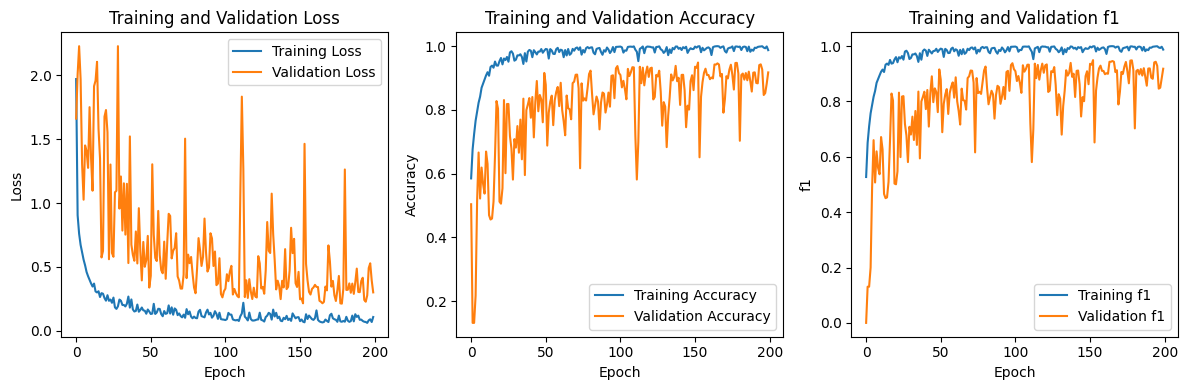

In [8]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot F1
plt.subplot(1, 3, 3)
plt.plot(history.history['f1'], label='Training f1')
plt.plot(history.history['val_f1'], label='Validation f1')
plt.title('Training and Validation f1')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
del x_train
del y_train

In [10]:
# model=load_model(base_dir+"models/mobilenet.keras",custom_objects={'f1':f1})
# model.summary()

In [11]:
y_pred=model.predict(x_test,batch_size=256)
y_pred = to_categorical(np.argmax(y_pred, axis=1), 4).astype(int)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

49/49 [==============================] - 2s 49ms/step


In [12]:
print(classification_report(y_test,y_pred,target_names=['WAKE','REM','LIGHT','DEEP']))

              precision    recall  f1-score   support

        WAKE       0.92      0.88      0.90      2810
         REM       0.87      0.95      0.91      1809
       LIGHT       0.93      0.93      0.93      6233
        DEEP       0.93      0.88      0.91      1598

    accuracy                           0.92     12450
   macro avg       0.91      0.91      0.91     12450
weighted avg       0.92      0.92      0.92     12450



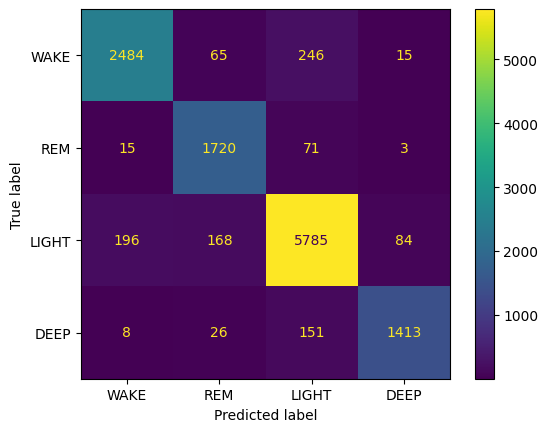

In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['WAKE','REM','LIGHT','DEEP'])
disp.plot()
plt.show()